Johannes Kepler University Linz  
Institute for Communications Engineering and RF-System 

# Signals and Systems 1

## Symbolic Convolution using SymPy

**Author:** Reinhard Feger 
___

## Usual initializations and imports

In [1]:
# static plots for publication:
%matplotlib inline
# If you want interactive plots use the following line. You need to run each plot cell seperately then
# %matplotlib widget
import matplotlib.pyplot as plt

import sympy as sym
sym.init_printing()

import numpy as np

from IPython.display import display, Math

## Convenient definitions

### Define symbolic variables for time and tell SymPy that they are real-valued

In [2]:
t = sym.symbols('t', real=True)
tau = sym.symbols('tau', real=True)

### Define rect-function by using SymPy's Piecewise function

In [3]:
rect = lambda x: sym.Piecewise((1, (x>-1/2) & (x<=1/2)), (0, True))
display(Math(r'\mathrm{rect(t)}='+sym.latex(rect(t))))

<IPython.core.display.Math object>

Check the result using a plot:

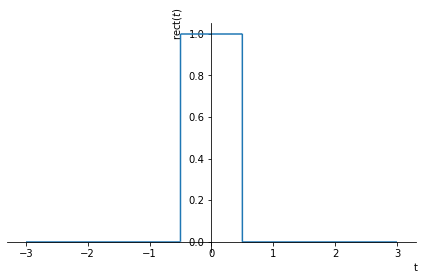

In [4]:
sym.plot(rect(t), (t, -3, 3), xlabel='t', ylabel='$\mathrm{rect}(t)$');

### Define symbolic convolution function

In [5]:
def conv(fct1, fct2, t, tau):
    return sym.integrate(fct1(tau)*fct2(t-tau), (tau, -sym.oo, sym.oo))

Check the resulting equation:

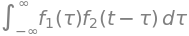

In [6]:
f1 = sym.Function('f_1')
f2 = sym.Function('f_2')
display(conv(f1,f2, t, tau))

This would also work in non-time domains:

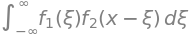

In [7]:
display(conv(f1,f2, sym.symbols('x'), sym.symbols('xi')))

## Some examples

### Convolve shifted rectangle with shifted Dirac delta

Two possibilities to define the functions:

In [8]:
# "full" function definition for the shifted rectangle
def fct1(x):
    return rect(x-2)
# shorter version using lambda for the shifted Dirac
fct2 = lambda x: sym.DiracDelta(x-4)

In [9]:
y1 = conv(fct1, fct2, t, tau)
display(Math(r'y_1(t)='+sym.latex(y1)))

<IPython.core.display.Math object>

What is the $\theta$ in the result?  
Let's print a textual representation

In [10]:
print(y1)

-Heaviside(5.5 - t) + Heaviside(6.5 - t)


We see that $\theta$ corresponds to the "Heaviside" function which we also know as unit step. We usually use $\sigma$ as a symbol in this course. Next we plot the result

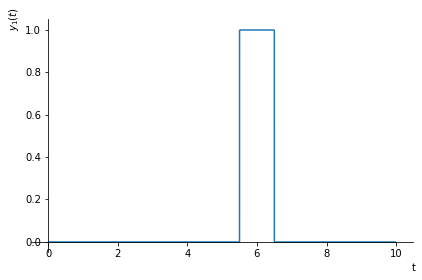

In [11]:
sym.plot(y1, (t, 0, 10), xlabel='t', ylabel='$y_1(t)$');

We see that $y_1$ is a rectangle shifted to the position 6 on the time axis.  
Note, that not the basic rectangle is shifted to the position of the Dirac, but the shifted rectangle is even shifted further

### Convolve shifted rectangle with two shifted Dirac deltas which are close to each other

We use the lambda-approach to define the two functions:

In [12]:
fct3 = lambda x: rect(x/5)  # wide rectangle
fct4 = lambda x: (sym.DiracDelta(x-1)+sym.DiracDelta(x))  # two Diracs spaced by 1

In [13]:
y2 = conv(fct3, fct4, t, tau)
display(Math(r'y_2(t)='+sym.latex(y2)))

<IPython.core.display.Math object>

Plotting the result shows that overlapping rectangles add up around the center of the resulting function

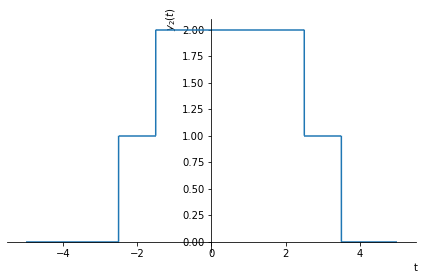

In [14]:
sym.plot(y2, (t, -5, 5), xlabel='t', ylabel='$y_2(t)$');

### Results are not always so easy to interpret: Convolve two rectangles

In [15]:
fct5 = lambda x: rect(x/2)  # wide rectangle
fct6 = lambda x: rect(x)  # basic rectangle

In [16]:
y3 = conv(fct5, fct6, t, tau)
display(Math(r'y_3(t)='+sym.latex(y3)))

<IPython.core.display.Math object>

SymPy is returning a combination of nested min/max operations instead of a piecewise function. However, the plot shows what is behind this equation.

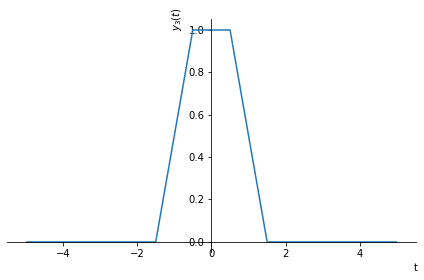

In [17]:
sym.plot(y3, (t, -5, 5), xlabel='t', ylabel='$y_3(t)$');

# Side note: How to lambdify the nested max/min functions?

Background: Often it is convenient to convert SymPy expressions to numpy for numerical evaluation. This can be done using the ```lambdify``` command. However, for $y_3$ this fails, because numpy does not offer the required min/max operations.

* Numpy has different min/max operations for different purposes, none seems to fit here
* We need to compare an arbitrary number of vectors (in $y_3$ we need three) if we want to make use of fast vectorized operations. There is a function in numpy that is able to deal with vectors/arrays/..., but this compares an arbitrary number of scalars which, for example, are combined in an array. However, what we need is something that can compare an arbitrary number of arrays/vectors/... per entry.

Workaround: Define our own min/max functions which are based on numpy's ```abs```

Important relations:
\begin{equation*}
\mathrm{max}(a,b)=\frac{a+b+|a+b|}{2}
\end{equation*}

\begin{equation*}
\mathrm{min}(a,b)=\frac{a+b-|a+b|}{2}
\end{equation*}

The ```numpy.abs``` function hopefully supports everything we encounter in practical applications

First, let's check what lambdify would produce without any help. We use the ```inspect.getsource``` function for this

In [18]:
y3_np_problem = sym.lambdify(t, y3, ['numpy'])
import inspect
print(inspect.getsource(y3_np_problem))

def _lambdifygenerated(t):
    return (-amax((-1.0,1.0*t - 0.5), axis=0) + amax((-1.0,1.0*t - 0.5,amin((1.0,1.0*t + 0.5), axis=0)), axis=0))



The following command will fail when we use an array as input:

In [19]:
y3_np_problem(np.arange(10))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Now let's use the two functions which can be found below

In [20]:
def mymax(tup, **kwargs):
    """max function supporting an arbitrary number of vectors
       (combined to tuples) to compare
       Parameters
       ----------
       tup : tuple
       kwargs : not used but required if caller adds things like axis (starting with sympy 1.6)
    """
    tmp = (tup[0]+tup[1]+np.abs(tup[0]-tup[1]))/2  # first two entries
    remaining = len(tup)-2
    cnt = 2
    while remaining>0:
        tmp = (tmp+tup[cnt]+np.abs(tmp-tup[cnt]))/2  # remaining entries
        remaining -= 1
        cnt += 1
    return tmp

def mymin(tup, **kwargs):
    """max function supporting an arbitrary number of vectors
       (combined to tuples) to compare
       Parameters
       ----------
       tup : tuple
       kwargs : not used but required if caller adds things like axis (starting with sympy 1.6)
    """
    tmp = (tup[0]+tup[1]-np.abs(tup[0]-tup[1]))/2  # first two entries
    remaining = len(tup)-2
    cnt = 2
    while remaining>0:
        tmp = (tmp+tup[cnt]-np.abs(tmp-tup[cnt]))/2  # remaining entries
        remaining -= 1
        cnt += 1
    return tmp

In [21]:
y3_np = sym.lambdify(t, y3, [{'amax': mymax, 'amin': mymin}, 'numpy'])

Does it work?

In [22]:
y3_np(np.arange(10))

array([1. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

It seems to be ok, so let's plot the numpy-based result 

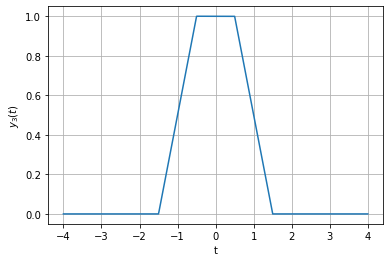

In [23]:
plt.close(5)
plt.figure(5)
plt.clf()
t_vec = np.linspace(-4, 4, 1000)
plt.plot(t_vec, y3_np(t_vec))
plt.grid(True)
plt.xlabel('t')
plt.ylabel('$y_3 (t)$');